In [1]:
import os
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import open3d as o3d
from tqdm.notebook import tqdm

from scipy.spatial.transform import Rotation
import copy

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Functions

In [2]:
def visualize_pcd(ref_cloud, color=False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp = source_temp.voxel_down_sample(voxel_size=0.15)
    target_temp = target_temp.voxel_down_sample(voxel_size=0.15)

    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

In [3]:
from scipy.ndimage import affine_transform

def transform_grid(grid, x, y, theta):
    shift_vector = np.array([x, y])
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

    center = np.array(grid.shape) / 2
    offset = center - rotation_matrix @ center
    offset += shift_vector

    grid_transformed = np.zeros(grid.size).reshape(grid.shape)
    grid_transformed = affine_transform(grid, rotation_matrix, offset=offset, order=0, mode='constant', cval=0)
    grid_transformed = grid_transformed.astype(np.uint8)
    return grid_transformed

def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()  # эта функция нигде не вызывается, оставляем так
    return pcd_transformed

In [4]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [5]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)

    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    
    if visualize:
        visualize_iou(grid_aligned)

    return intersection / union

def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)

    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, visualize=False):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)

    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize)
    except ZeroDivisionError:
        return 0
    except Exception as e:
        print(e)
        return 0

In [6]:
def angle_between_vecs(vec1, vec2):
    return np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

In [7]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    # print(estimated_x, gt_x)
    # print(estimated_y, gt_y)
    # print(estimated_angle, gt_angle)
    # print(angle_between_vecs([estimated_x, estimated_y], [gt_x, gt_y]))
    # print(normalize(gt_angle - estimated_angle))
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

def rotate(x, y, angle):
    x_new = x * np.cos(angle) + y * np.sin(angle)
    y_new = -x * np.sin(angle) + y * np.cos(angle)
    return x_new, y_new

def get_rel_pose(x, y, theta, x2, y2, theta2):
    rel_x, rel_y = rotate(x2 - x, y2 - y, theta)
    return [rel_x, rel_y, normalize(theta2 - theta)]

# Metrics

In [8]:
from dataclasses import dataclass, asdict

@dataclass
class RegistrationResult:
    method_name: str
    data_cloud: str
    candidate_idx: int
    iou: float
    dist: float
    fitness: float
    transform: list
    error: list

In [9]:
import json

def save_results(filename, arr):
    data_to_save = [asdict(el) for el in arr]
    with open(f'{filename}.json', 'w') as file:
        json.dump(data_to_save, file)


def load_results(filename):
    with open(f'{filename}.json', 'r') as file:
        return [RegistrationResult(**x) for x in json.load(file)]

In [10]:
def calc_precision_recall_f1(results, threshold):
    precision = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results]) / \
                        np.sum([(el.fitness > threshold) for el in results])
    recall = np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                                for el in results if el.iou > 0.5]) / \
                        np.sum([el.iou > 0.5 for el in results])
    f1 = 2 * precision * recall / (precision + recall)

                                                # for el in results]) / \
    return precision, recall, f1

def print_precision_recall(results, method, threshold):
    precision, recall, f1 = calc_precision_recall_f1(results, threshold)

    print(f'Precision {method}: {precision:.3f}')
    print(f'Recall {method}: {recall:.3f}', )
    print(F'F1 score {method}: {f1:.3f}')

In [46]:
# results_fastmac = load_results('fastmac_res_eval')
results_fastmac = load_results('fastmac_no_floor_fix')
results_icp = load_results('icp_fcgf_fix')

In [14]:
results_fastmac.sort(key=lambda x: (x.data_cloud, x.candidate_idx))
results_icp.sort(key=lambda x: (x.data_cloud, x.candidate_idx))

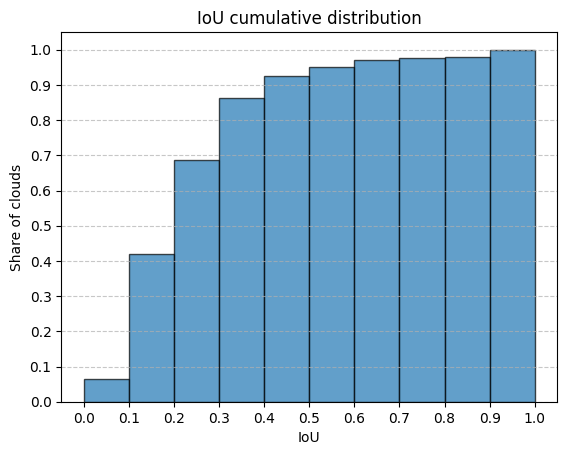

In [47]:
plt.hist([el.iou for el in results_fastmac], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('IoU')
plt.ylabel('Share of clouds')
plt.title('IoU cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

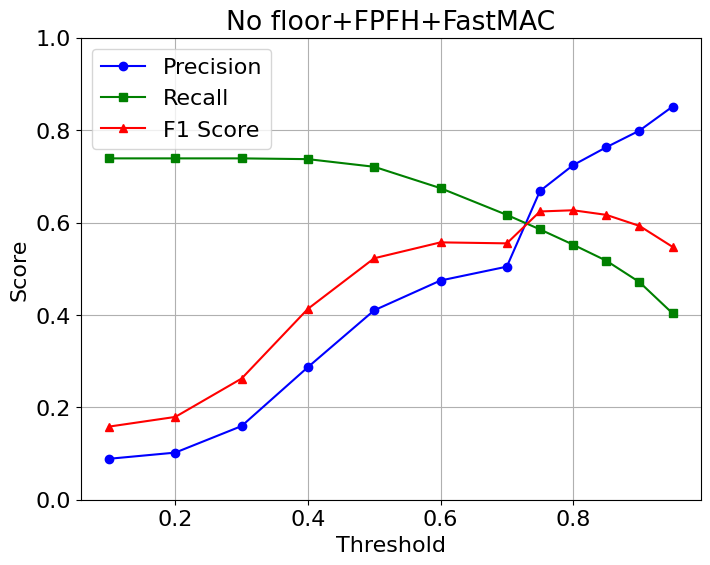

In [51]:
precisions = []
recalls = []
f1s = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


for threshold in thresholds:
    precision, recall, f1 = calc_precision_recall_f1(results_fastmac, threshold)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision', color='blue')
plt.plot(thresholds, recalls, marker='s', label='Recall', color='green')
plt.plot(thresholds, f1s, marker='^', label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('No floor+FPFH+FastMAC')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [50]:
print_precision_recall(results_fastmac, 'FastMAC', 0.8)

Precision FastMAC: 0.724
Recall FastMAC: 0.552
F1 score FastMAC: 0.627


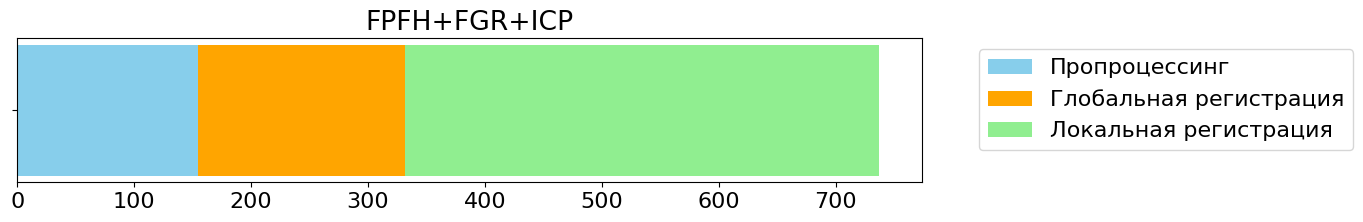

In [82]:
mean_times = [155, 177, 405]
labels = ['Пропроцессинг', 'Глобальная регистрация', 'Локальная регистрация']

total_time = sum(mean_times)

plt.figure(figsize=(14, 2.5))
bar_height = 0.8

plt.barh([''], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh([''], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
plt.barh([''], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
# plt.barh([''], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='salmon')
# plt.barh([''], [mean_times[4]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2] + mean_times[3]], color='white')
# plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

# for i, time in enumerate(mean_times[:-1]):
#     x_position = sum(mean_times[:i]) + time / 2
#     plt.text(x_position, 0, f'{time:.0f}', ha='center', va='center', color='black', fontsize=10)

# plt.xlabel('Time')
plt.title('FPFH+FGR+ICP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [85]:
plt.rcParams.update({'font.size': 17})

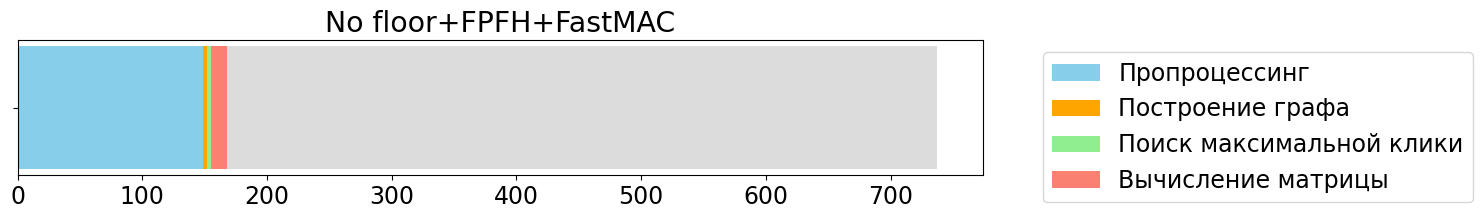

In [90]:
mean_times = [149, 3, 3, 13, 569]
labels = ['Пропроцессинг', 'Построение графа', 'Поиск максимальной клики', 'Вычисление матрицы']

total_time = sum(mean_times)

plt.figure(figsize=(15.25, 2.5))
bar_height = 0.8

plt.barh([''], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh([''], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
plt.barh([''], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
plt.barh([''], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='salmon')
plt.barh([''], [mean_times[4]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2] + mean_times[3]], color='gainsboro')
# plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

# for i, time in enumerate(mean_times[:-1]):
#     x_position = sum(mean_times[:i]) + time / 2
#     plt.text(x_position, 0, f'{time:.0f}', ha='center', va='center', color='black', fontsize=10)

# plt.xlabel('Time')
plt.title('No floor+FPFH+FastMAC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

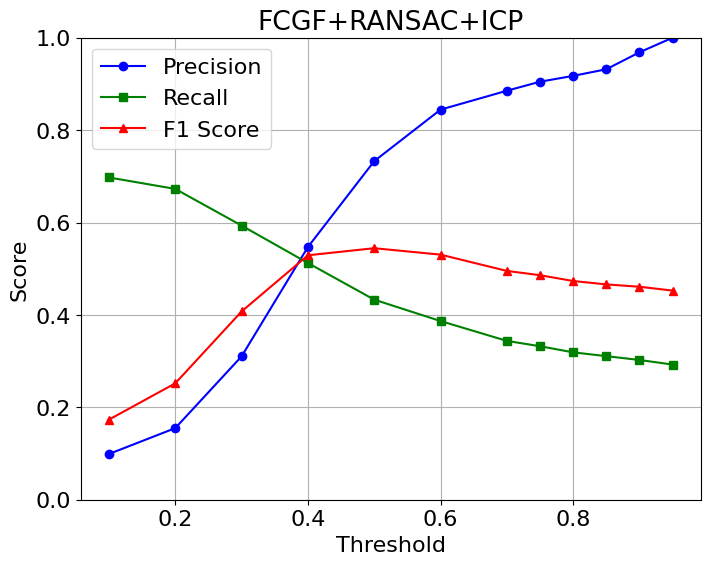

In [35]:
precisions = []
recalls = []
f1s = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    precision, recall, f1 = calc_precision_recall_f1(results_icp, threshold)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Precision', color='blue')
plt.plot(thresholds, recalls, marker='s', label='Recall', color='green')
plt.plot(thresholds, f1s, marker='^', label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FCGF+RANSAC+ICP')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [21]:
print_precision_recall(results_icp, 'ICP', 0.5)

Precision ICP: 0.733
Recall ICP: 0.433
F1 score ICP: 0.544


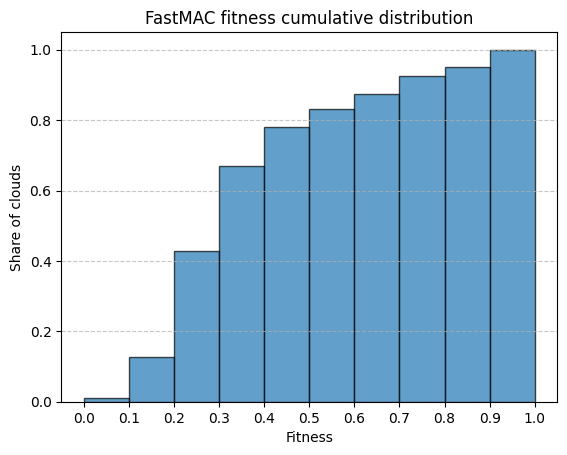

In [38]:
plt.hist([el.fitness for el in results_fastmac], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('Fitness')
plt.ylabel('Share of clouds')
plt.title('FastMAC fitness cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

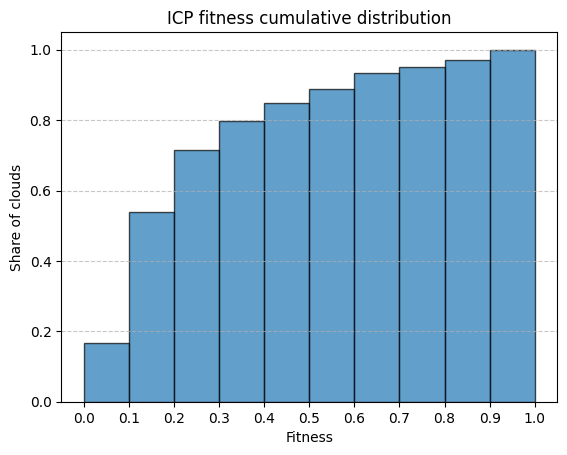

In [37]:
plt.hist([el.fitness for el in results_icp], bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7, cumulative=True, density=True)

plt.xlabel('Fitness')
plt.ylabel('Share of clouds')
plt.title('ICP fitness cumulative distribution')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

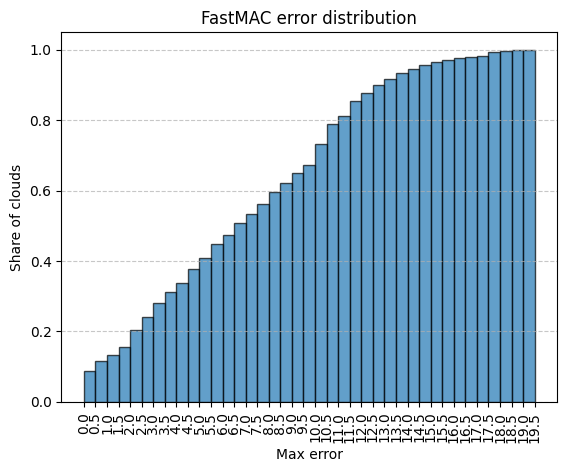

In [66]:
plt.hist([max(el.error) for el in results_fastmac], bins=np.arange(0, 20, 0.5), edgecolor='black', alpha=0.7, density=True, cumulative=True)

plt.xlabel('Max error')
plt.ylabel('Share of clouds')
plt.title('FastMAC error distribution')
plt.xticks(np.arange(0, 20, 0.5), rotation=90)
# plt.ylim((0, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

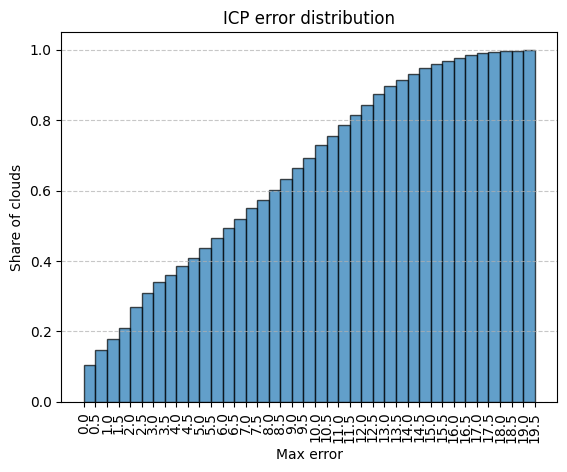

In [56]:
plt.hist([max(el.error) for el in results_icp], bins=np.arange(0, 20, 0.5), edgecolor='black', alpha=0.7, density=True, cumulative=True)

plt.xlabel('Max error')
plt.ylabel('Share of clouds')
plt.title('ICP error distribution')
plt.xticks(np.arange(0, 20, 0.5), rotation=90)
# plt.ylim((0, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

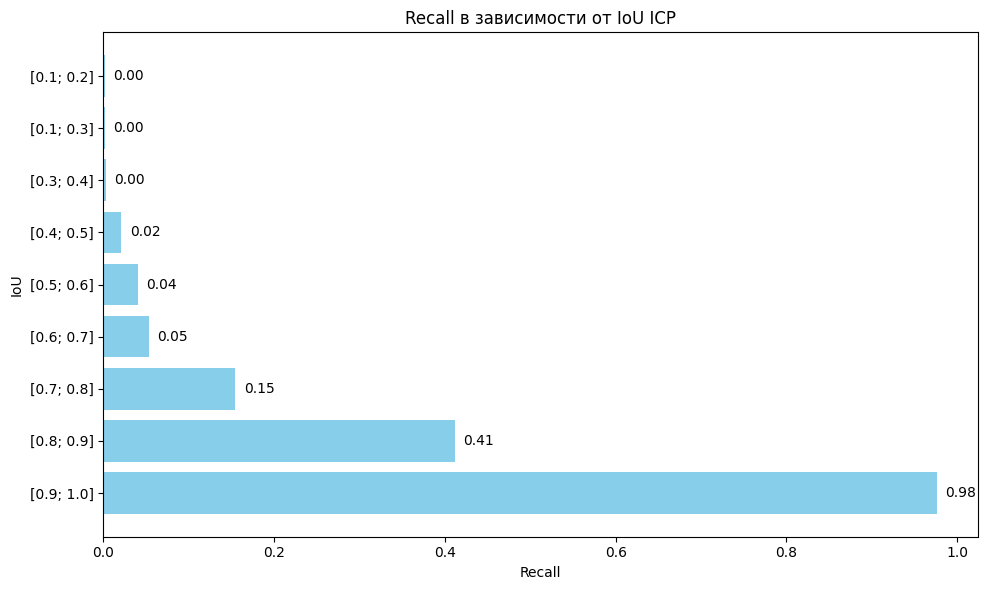

In [34]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
amount = [(np.sum([(el.fitness > 0.6) * (max(el.error) < 0.5) for el in results_icp if (t <= el.iou <= t + 0.1)]) / np.sum([1 for el in results_icp if (t <= el.iou <= t + 0.1)])) for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, amount, color='skyblue')
plt.xlabel('Recall')
plt.ylabel('IoU')
plt.title('Recall в зависимости от IoU ICP')

for i, v in enumerate(amount):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


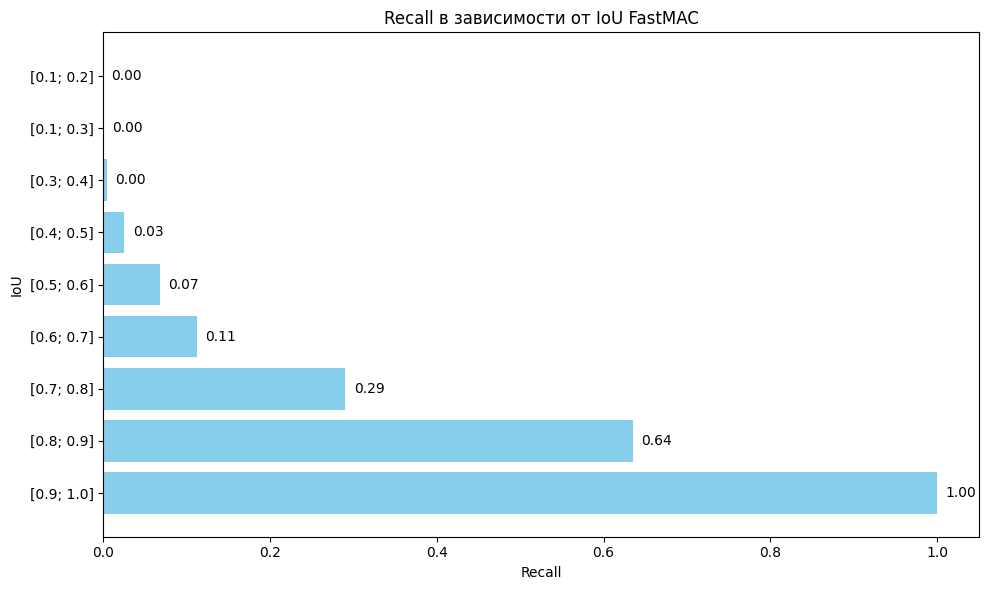

In [33]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
amount = [(np.sum([(el.fitness > 0.75) * (max(el.error[:-1]) < 0.5) for el in results_fastmac if (t <= el.iou <= t + 0.1)]) / np.sum([1 for el in results_fastmac if (t <= el.iou <= t + 0.1)])) for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, amount, color='skyblue')
plt.xlabel('Recall')
plt.ylabel('IoU')
plt.title('Recall в зависимости от IoU FastMAC')

for i, v in enumerate(amount):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


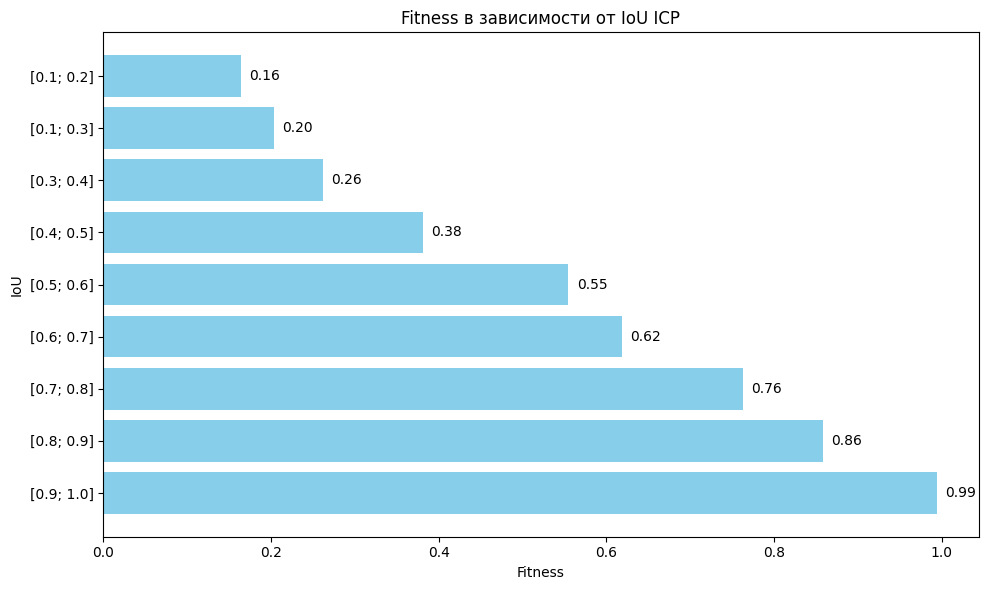

In [32]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
amount = [np.mean([el.fitness for el in results_icp if (t <= el.iou <= t + 0.1)]) for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, amount, color='skyblue')
plt.xlabel('Fitness')
plt.ylabel('IoU')
plt.title('Fitness в зависимости от IoU ICP')

for i, v in enumerate(amount):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

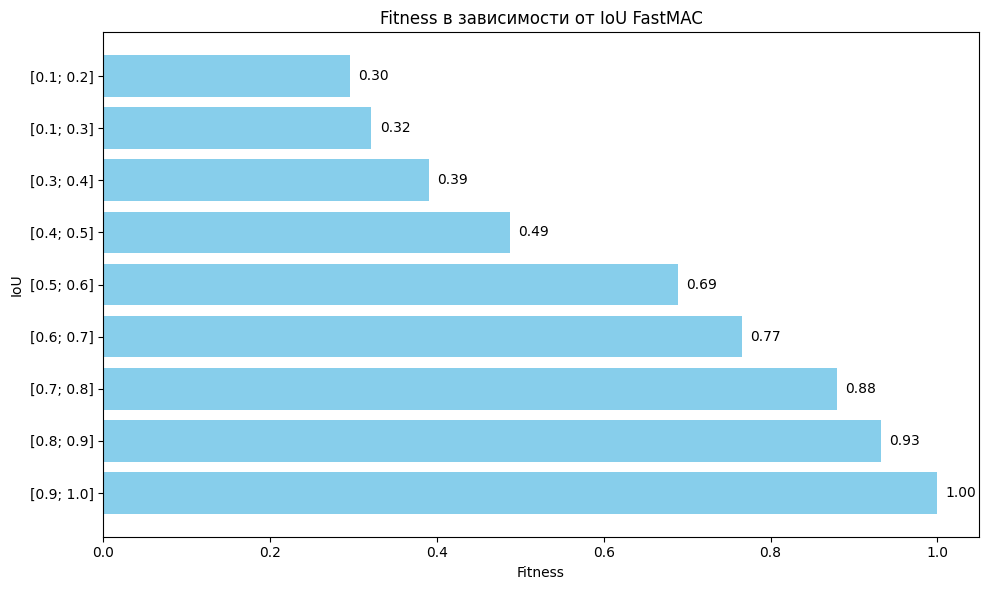

In [31]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
amount = [np.mean([el.fitness for el in results_fastmac if (t <= el.iou <= t + 0.1)]) for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, amount, color='skyblue')
plt.xlabel('Fitness')
plt.ylabel('IoU')
plt.title('Fitness в зависимости от IoU FastMAC')

for i, v in enumerate(amount):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [51]:
threshold = 0.4

In [54]:
np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) for el in results_icp]), np.sum([(el.fitness > threshold) for el in results_icp])

(468, 725)

In [55]:
np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) for el in results_fastmac]), np.sum([(el.fitness > threshold) for el in results_fastmac])

(405, 2335)

In [17]:
np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) for el in results_fastmac]), np.sum([(el.fitness > threshold) for el in results_fastmac])

(325, 533)

In [ ]:
print('Number of correct ICP matches with IoU > 0.5:', np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                              for el in results_icp if el.iou > 0.5]))

In [ ]:
print('Number of correct FastMac matches with IoU > 0.5:', np.sum([(el.fitness > threshold) * (max(el.error) < 0.5) \
                                              for el in results_fastmac if el.iou > 0.5]))

In [ ]:
# FastMac выбивает большой fitness примерно также как и ICP, но 
# Precision такой низкий, потому что много облаков точек имеет fitness > 0.7, 1242 против 539 у ICP. При этом количество облаков, на которых error меньше 0.5 практически столько же 220 против 254
# Если брать не обратную матрицу, то результат ещё ближе - 244 облака, а fitness > 0.7 имеет 1733 облака

In [14]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

  0%|          | 0/8023 [00:00<?, ?it/s]

RegistrationResult(method_name='fastmac_no_floor', data_cloud='1710496259327026000', candidate_idx=0, iou=0.794292336665218, dist=0.22364200327918432, fitness=1.0, transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]], error=[0.09998331218957901, 0.20004770159721375, 1.5707963398452485])
[0.09998331218957901, 0.20004770159721375, 1.5707963398452485]


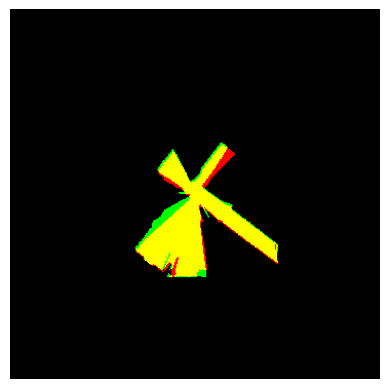

0.794292336665218


In [54]:
for res in tqdm(results_fastmac):
    if not (res.fitness > 0.75 and max(res.error) >= 0.5 and max(res.error[:-1]) < 0.5):
        continue

    test_dir = os.path.join(pr_data_dir, res.data_cloud)

    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    i = res.candidate_idx

    idx = transforms_[i, 0]
    gt_pose = cand_poses[int(idx)]
    pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

    # Candidate cloud (from graph of locations)
    cloud = cand_clouds[idx][:, :3]
    cloud = cloud[cloud == cloud].reshape((-1, 3))

    print(res)
    print(res.error)
    print(get_iou(*pose_shift, ref_cloud, cloud, visualize=True))

    break

Test cloud data_cloud='1710495383028300000', candidate_idx=1

In [21]:
fastmac_errors = []

In [13]:
for res_icp, res_icp_no_fix in zip(results_icp, results_icp_no_fix):
    if max(res_icp.error) < 0.5 and max(res_icp_no_fix.error) > 0.5:
        print(res_icp.data_cloud, res_icp.candidate_idx)
        print(res_icp_no_fix.data_cloud, res_icp_no_fix.candidate_idx)

        # show_difference(res_fastmac.data_cloud, res_fastmac.candidate_idx)

1710495368999633000 0
1710495368999633000 0
1710495370798204000 0
1710495370798204000 0


In [ ]:
for res_fastmac in results_fastmac:
    if (res_fastmac.fitness > 0.8 and max(res_fastmac.error) > 0.5):
        print(res_fastmac.data_cloud, res_fastmac.candidate_idx)
        # fastmac_errors.append((res_fastmac.data_cloud, res_fastmac.candidate_idx))

        # show_difference(res_fastmac.data_cloud, res_fastmac.candidate_idx)

data cloud = 1710495376757307000 candidate idx = 0

In [19]:
def show_difference(datacloud, candidate_idx, display=False):
    res_icp = None
    res_fastmac = None

    for i in range(len(results_fastmac)):
        if results_fastmac[i].data_cloud == datacloud and results_fastmac[i].candidate_idx == candidate_idx:
            res_fastmac = results_fastmac[i]
            res_icp = results_icp[i]

    test_dir = os.path.join(pr_data_dir, res_icp.data_cloud)

    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        return

    if transforms_.size == 0:
        return
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    i = res_icp.candidate_idx

    idx = transforms_[i, 0]
    gt_pose = cand_poses[int(idx)]
    pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

    # Candidate cloud (from graph of locations)
    cloud = cand_clouds[idx][:, :3]
    cloud = cloud[cloud == cloud].reshape((-1, 3))

    # print(pose_shift)
    # print(transformation_error(pose_shift, np.linalg.inv(res_icp.transform)))
    # print(f"{res_icp_no_fix.error}->{res_icp.error}")
    # print(f"{res_fastmac_no_fix.error}->{res_fastmac.error}")
    # print(transformation_error(pose_shift, np.linalg.inv(res_icp_no_fix.transform)))
    # print('======================')
    # print(transformation_error(pose_shift, np.linalg.inv(res_icp.transform)))
    # print(transformation_error(pose_shift, np.array(np.linalg.inv(res_fastmac.transform))), res_fastmac.error)
    # # print(transformation_error(pose_shift, np.array(res_icp.transform)))
    # print(o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.3, np.linalg.inv(res_fastmac.transform)))
    # print(o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.3, res_icp.transform))

    # print("ICP: ", end='')
    # print(res_icp.fitness, res_icp.error)

    # print("FastMAC: ", end='')
    # print(res_fastmac.fitness, res_fastmac.error)

    # visualize_pcd(cloud)
    # visualize_pcd(np.array(make_pcd_from_array(ref_cloud).transform(res_fastmac.transform).points))

    # print(np.linalg.inv(res_icp.transform), res_fastmac.transform)

    # print(np.array(res_fastmac_no_fix.er))
    # print('==============')
    # print(np.array(res_fastmac.transform))
    # print(res_icp)

    # print(pose_shift)

    draw_registration_result(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), np.eye(4), 'No registration')
    if display:
        # draw_registration_result(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), res_icp_no_fix.transform, 'ICP no fix registration')
        draw_registration_result(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), res_icp.transform, 'ICP registration')
        # draw_registration_result(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), res_fastmac.transform, 'FastMAC registration')
        # draw_registration_result(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), np.linalg.inv(res_fastmac_no_fix.transform), 'FastMAC no fix registration')

    return

In [ ]:
for ii, test_name in (pbar := tqdm(list(enumerate(os.listdir(pr_data_dir))))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size)


In [ ]:
show_difference('1710505321184309000', 0, False)

In [ ]:
show_difference('1710506768661198000', 0, True)

In [ ]:
show_difference('1710506802315913000', 0, False)

[0.2026956093276583, 0.5151941194418875, 1.2163545134773151e-05]->[0.2026956093276583, 0.5151941194418875, 1.2163545134773151e-05]
[1.3163791375188498, 0.086727187529063, 0.0011368267561620645]


In [79]:
for ii in tqdm(range(len(results_fastmac))):
    test_dir = os.path.join(pr_data_dir, results_fastmac[ii].data_cloud)

    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    i = results_fastmac[ii].candidate_idx

    idx = transforms_[i, 0]
    gt_pose = cand_poses[int(idx)]
    pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

    results_fastmac[ii].error = transformation_error(pose_shift, np.linalg.inv(results_fastmac[ii].transform))
    results_fastmac[ii].transform = list([list(el) for el in np.linalg.inv(results_fastmac[ii].transform).astype(float)])

    # Candidate cloud (from graph of locations)
    # cloud = cand_clouds[idx][:, :3]
    # cloud = cloud[cloud == cloud].reshape((-1, 3))

    # results_fastmac[i].fitness = o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.4, np.linalg.inv(res_fastmac.transform)).fitness

  0%|          | 0/8025 [00:00<?, ?it/s]

In [80]:
save_results('fastmac_no_floor_fix', results_fastmac)

In [57]:
np.sum([max(el.error) < 0.5 for el in results_icp_no_fix])

264

In [58]:
np.sum([max(el.error) < 0.5 for el in results_icp])

265

In [61]:
np.sum([max(el.error) < 0.5 for el in results_icp_no_fix])

658

In [46]:
for res_fastmac, res_fastmac_no_fix in zip(results_icp, results_icp_no_fix):
    if max(res_fastmac.error) < 0.5 and max(res_fastmac_no_fix.error) > 0.5:
        print(res_fastmac.data_cloud, res_fastmac.candidate_idx)
        # show_difference(res_fastmac.data_cloud, res_fastmac.candidate_idx)

1710495368999633000 0
1710495370798204000 0


In [ ]:
show_difference('1710495368999633000', 0, True)